In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from superrad import ultralight_boson as ub

#orig_path= "/Users/sebhoof/Research/BHSR/"
#sys.path.append("../code_matt/")
#from BH_functions import stellar_functions

from py.plotting import *
from py.constants import *
from py.bhsr import *
from py.bosenova import *
from py.kerr_bh import *

set_style(gs=9, lts=9, lfs=8, lbls=9, tls=9)

!mkdir -p figures

### Compare BHSR rates

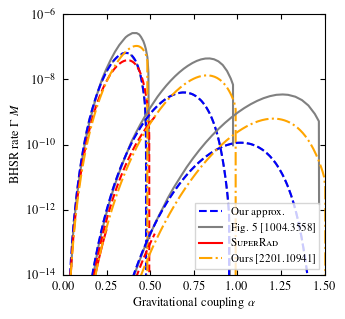

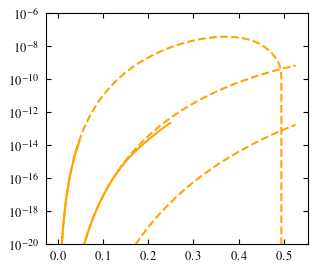

In [3]:
states = [(ell+1, ell, ell) for ell in range(1,4)]
astar0 = 0.999
mbh0 = 10.0 # Msol

def mu_to_alpha(mu, mbh=mbh0, units=1e-12):
    return alpha(mu*units, mbh)
def alpha_to_mu(alph, mbh=mbh0, units=1e-12):
    return alph/(units*rg(mbh))

"""
masha_bhsr_rates = []
for i in range(1,5):
    data = np.genfromtxt("data/1411_2263/ell_{:d}".format(i))
    masha_bhsr_rates.append(data)
""";

muvals_small = np.linspace(0.01, 7, 200)*1e-12
alphvals_small = mu_to_alpha(muvals_small, units=1)
muvals = np.linspace(0.01, 25, 250)*1e-12
alphvals = mu_to_alpha(muvals, units=1)
bc1 = ub.UltralightBoson(spin=0, model="non-relativistic")
bc2 = ub.UltralightBoson(spin=0, model="relativistic")

fig, ax = plt.subplots(figsize=(mnras_width,mnras_width))

for s in states:
    n, l, m = s
    # p0 = ax.plot(muvals/1e-12, GammaSR_nlm(muvals, mbh0, astar0, n, l, m)*rg(mbh0), 'r', label=r"Ours (Dettweiler)")
    grates = []
    for mu in muvals:
        _, om1 = omega_nlm_bxzh(mu, mbh0, astar0, n, l, m)
        grates.append(om1*rg(mbh0))
    d = np.genfromtxt("data/1004_3558/1004_3558_fig5_ell_{:d}_nr".format(l))
    p2 = ax.plot(d[:,0], d[:,1], '--', c='gray', label=r"Fig. 5 [1004.3558] (NR)")
    d = np.genfromtxt("data/1004_3558/1004_3558_fig5_ell_{:d}_r".format(l))
    p6 = ax.plot(d[:,0], d[:,1], '-', c='gray', label=r"Fig. 5 [1004.3558]")
    p1 = ax.plot(alphvals, GammaSR_nlm_nr(muvals, mbh0, astar0, n, l, m)*rg(mbh0), c='blue', ls='--', label=r"Our approx.")
    superrad_bhsr_rates1 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc1, m)*rg(mbh0) for mu in muvals_small]
    superrad_bhsr_rates2 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc2, m)*rg(mbh0) for mu in muvals_small]
    p3 = ax.plot(alphvals_small, superrad_bhsr_rates1, c='red', ls='--', label=r"\textsc{SuperRad} (NR)")
    p4 = ax.plot(alphvals_small, superrad_bhsr_rates2, c='red', ls='-', label=r"\textsc{SuperRad}")
    p5 = ax.plot(alphvals, grates, c='orange', ls='-.', label=r"Ours [2201.10941]")
ax.legend(handles=p1+p6+p4+p5, frameon=True)#, title=r"$M = {:.0f}\,M_\odot$, $a_\ast = {:.3f}$".format(mbh0, astar0))
#secax = ax.secondary_xaxis('top', functions=(alpha_to_mu, mu_to_alpha))
#secax.set_xlabel(r"ULB mass $\mu$ [$10^{-12}$ eV]")
ax.set_xlabel(r"Gravitational coupling $\alpha$")
ax.set_ylabel(r"BHSR rate $\Gamma\,M$")
ax.set_xlim([0, 1.5])
ax.set_ylim([1e-14, 1e-6])
#axset_xscale('log')
ax.set_yscale('log')
fig.savefig("figures/rate_comparison.pdf", backend='pgf')
plt.show()

for s in states:
    *_, m = s
    superrad_bhsr_rates1 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc1, m)*rg(mbh0) for mu in muvals_small]
    superrad_bhsr_rates2 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc2, m)*rg(mbh0) for mu in muvals_small]
    plt.plot(alphvals_small, superrad_bhsr_rates1, c='orange', ls='--')
    plt.plot(alphvals_small, superrad_bhsr_rates2, c='orange', ls='-')
plt.yscale('log')
plt.ylim([1e-20, 1e-6])
plt.show()

### Plot some Regge slopes for our BHSR rates

In [6]:
ma_test = 7e-12
states = np.array([(i,j,j) for i in range(7) for j in range(1,i)])

# Compute Regge slopes for our SR rate approx and many states

m_bh_vals = np.arange(-1, 2, 0.02)
ma0 = 4.3e-12
a_vals_2 = compute_regge_slopes(ma0, 10**m_bh_vals, states)
approx_regge_slope = interp1d(m_bh_vals, [np.nanmin(a) for a in a_vals_2])

foo = lambda mu, mbh, a: GammaSR_nlm_nr(mu, mbh, a)
a_vals_3 = compute_regge_slopes_given_rate(ma0, 10**m_bh_vals, foo)

# Compare to the final spin from superrad
# N.B. Superrad evolves the spin until there is 1 boson left in the cloud!
# This can leads to an evolution over time scales longer than the age of the BH etc.

a_vals_4 = []
bc = ub.UltralightBoson(spin=0, model="relativistic")
for mbh in 10**m_bh_vals:
   try:
      wf = bc.make_waveform(mbh, 0.99, ma0, units="physical")
      a_vals_4.append(wf.spin_bh_final())
   except:
      a_vals_4.append(np.nan)

/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_41792/3094493789.py:9: RuntimeWarning: All-NaN slice encountered
  approx_regge_slope = interp1d(m_bh_vals, [np.nanmin(a) for a in a_vals_2])


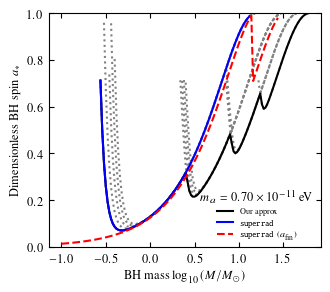

In [7]:
cond = (m_bh_vals > 0)

fig, ax = plt.subplots()

for i,s in enumerate(states):
    p1 = ax.plot(m_bh_vals, a_vals_2[:,i], c='gray', ls=':') #, label='$|{:d}{:d}{:d}\\rangle$'.format(*s))
p1 = ax.plot(m_bh_vals, approx_regge_slope(m_bh_vals), c='k', ls='-', label='Our approx')
p2 = ax.plot(m_bh_vals, a_vals_3, c='blue', lw=1.5, label=r"\texttt{superrad}")
p3 = ax.plot(m_bh_vals, a_vals_4, c='red', lw=1.5, ls='--', label=r"\texttt{superrad} ($a_\mathrm{fin}$)")

ax.set_xlabel('BH mass $\log_{10}(M/M_\odot)$')
ax.set_ylabel('Dimensionless BH spin $a_*$')
ax.set_ylim([0,1])
#ax.set_xlim([-1,2])

leg = ax.legend(handles=p1+p2+p3, frameon=False, loc=4, title='$m_a = {}\,$eV'.format(sci_format(ma_test)), fontsize=6)
#leg.get_title().set_fontsize('8')

fig.tight_layout()
fig.savefig("figures/regge_slope.pdf", dpi=300, backend='pgf')
plt.show()